# Outline

Here I fine tuned `inception` model trained in `ImageNet` for binary classification **whether there is a brown bear on the picture**.

# Imports

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import IPython

from PIL import Image
from torchvision import datasets, transforms
from IPython.display import display
from sklearn.metrics import accuracy_score, recall_score, precision_score
from methods import (
    train_model,
    initialize_inception_model,
    test_model
)

SEED = 42
np.random.seed(SEED)
# random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/andrey/Projects/kontur2023/.conda/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Model initialization

I tried different configurations of learning process.
The best performance was gained with **10 lower unfreezed layers**.

In [2]:
num_classes = 2
num_unfreezed_layers = 10

model, input_size = initialize_inception_model(num_classes, num_unfreezed_layers)

Inception model was loaded sucessfully.


# Data

`"./bears_image_folder"` is data separated to **stratified** _train valid test split_ according to `torchivison ImageFolder` format. This directory was created in `data_preparation.ipynb`.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "./bears_image_folder"
batch_size = 8

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Training

In [4]:
print("Params to learn:")

params_to_learn = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_learn.append(param)
        print("\t",name)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 Mixed_7c.branch3x3dbl_3a.bn.weight
	 Mixed_7c.branch3x3dbl_3a.bn.bias
	 Mixed_7c.branch3x3dbl_3b.conv.weight
	 Mixed_7c.branch3x3dbl_3b.bn.weight
	 Mixed_7c.branch3x3dbl_3b.bn.bias
	 Mixed_7c.branch_pool.conv.weight
	 Mixed_7c.branch_pool.bn.weight
	 Mixed_7c.branch_pool.bn.bias
	 fc.weight
	 fc.bias


In [61]:
optimizer_ft = optim.SGD(params_to_learn, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 15

model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.7704 Acc: 0.7222
val Loss: 0.2483 Acc: 0.9756

Epoch 1/14
----------
train Loss: 0.4742 Acc: 0.8735
val Loss: 0.2056 Acc: 0.9512

Epoch 2/14
----------
train Loss: 0.4033 Acc: 0.8704
val Loss: 0.1463 Acc: 0.9512

Epoch 3/14
----------
train Loss: 0.4359 Acc: 0.8796
val Loss: 0.1249 Acc: 0.9512

Epoch 4/14
----------
train Loss: 0.4152 Acc: 0.8889
val Loss: 0.1070 Acc: 0.9756

Epoch 5/14
----------
train Loss: 0.3530 Acc: 0.8981
val Loss: 0.0797 Acc: 0.9756

Epoch 6/14
----------
train Loss: 0.4366 Acc: 0.8673
val Loss: 0.1104 Acc: 0.9512

Epoch 7/14
----------
train Loss: 0.4089 Acc: 0.8889
val Loss: 0.0936 Acc: 0.9756

Epoch 8/14
----------
train Loss: 0.3666 Acc: 0.8889
val Loss: 0.0607 Acc: 1.0000

Epoch 9/14
----------
train Loss: 0.3275 Acc: 0.9043
val Loss: 0.0967 Acc: 0.9756

Epoch 10/14
----------
train Loss: 0.4129 Acc: 0.8519
val Loss: 0.0483 Acc: 1.0000

Epoch 11/14
----------
train Loss: 0.3676 Acc: 0.8981
val Loss: 0.0656 Acc: 0.9756

Ep

As we can notice the model has better performace on valid than train data. It happens because of augmentations. Train data is more complicated than valid and test, so model shows worse results on train but it is good at generalization and performes very good on valid and test.

# Testing

Let's finially evaluate the model on test data.

In [6]:
transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
y_true, y_pred = test_model(model, test_loader)

In [64]:
accuracy_score(y_true, y_pred)

1.0

In [65]:
recall_score(y_true, y_pred)

1.0

In [66]:
precision_score(y_true, y_pred)

1.0

As we can see, model obtained **1.0** in all key metrics even on test data.

In [ ]:
torch.save(model.state_dict(), f'./models/best_inception.pt')

# How to make predictions on a single image.

Let's now write inference method to use this fine tuned inception with YOLO8.

In [ ]:
model, input_size = initialize_inception_model(num_classes)
model.load_state_dict(torch.load(f'./models/best_inception.pt', map_location=device))
model.eval()

Let's test model on image generated by myself from Stable Diffusion.

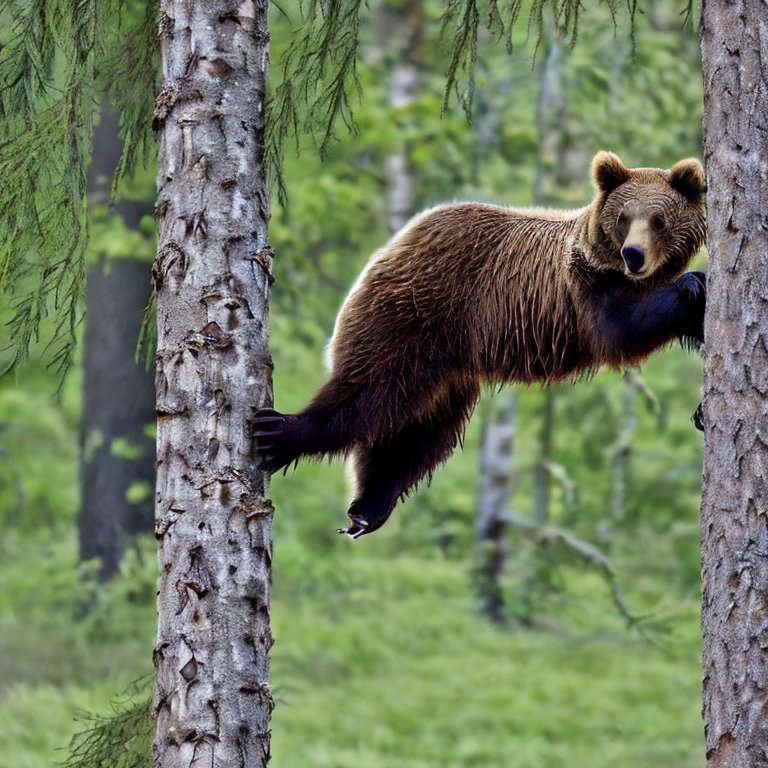

In [12]:
display(IPython.display.Image(filename='./generated/tree3.jpeg'))

In [14]:
img = Image.open('./generated/tree3.jpeg')
batch = transform(img).unsqueeze(0)
with torch.no_grad():
    out = model(batch.to(device)).squeeze(0)
np.argmax(out.tolist())

1

Predicted label is true.

In [15]:
[1, 2, 3, 4][:None]

[1, 2, 3, 4]